# Predicting Student Dropout Through Machine Learning


## Table of Contents
[1. Project Overview](#1-project-overview)

[2. Installing and Importing Libraries](#2-installing-and-importing-libraries)
[3. Data Preparation](#3-data-preparation)
- [3.1 Loading and Inspecting the Data](#31-loading-and-inspecting-the-data)
- [3.2 Handling Missing Data](#32-handling-missing-data)
- [3.3 Feature Selection and Engineering](#33-feature-selection-and-engineering)
- [3.4 Train-Test Split and Scaling](#34-train-test-split-and-scaling)

[4. XGBoost Model Development and Optimisation](#4-xgboost-model-development-and-optimisation)
- [4.1 Baseline XGBoost Model (Without Attendance Data)](#41-baseline-xgboost-model-without-attendance-data)
- [4.2 Hyperparameter Tuning for XGBoost Model](#42-hyperparameter-tuning-for-xgboost-model)
- [4.3 Optimised XGBoost Model](#43-optimised-xgboost-model)

[5. Neural Network Model Development and Optimisation](#5-neural-network-model-development-and-optimisation)
- [5.1 Baseline Neural Network Model (Without Attendance Data)](#51-baseline-neural-network-model-without-attendance-data)
- [5.2 Neural Network Hyperparameter Tuning](#52-neural-network-hyperparameter-tuning)
- [5.3 Optimised Neural Network](#53-optimised-neural-network)

[6. Final Model Comparison](#6-final-model-comparison)

[7. Conclusion](#7-conclusion)
- [7.1 Key Takeaways](#71-key-takeaways)
- [7.2 Next Steps](#72-next-steps)




## 1. Project Overview

In this project, we develop a predictive model to classify student dropouts using supervised learning. We explore the impact of various student attributes—academic performance, demographic factors, and attendance data—on dropout likelihood. The goal is to identify at-risk students early and provide actionable insights for intervention.

## 2. Installing and Importing Libraries

In [ ]:
# Install Keras Tuner
!pip install keras-tuner


In [ ]:
# Importing necessary libraries for data manipulation, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Setting seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 3. Data Preparation

### Loading & Inspecting the Data

We load a course-level dataset containing demographic details, course information, and attendance-related columns. Prior to modeling, we briefly inspect the data (e.g., via `head()` or summary statistics) to confirm we have the correct fields and to gauge the distribution of our target variable.


In [ ]:
# Loading the dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the dataset
file_path = '/content/drive/MyDrive/CourseLevelDatasetVersion2.csv'
data = pd.read_csv(file_path)
data.head()

,CentreName,AcademicYear,LearnerCode,BookingId,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,...,CreditWeightedAverage,ProgressionDegree,ProgressionUniversity,EligibleToProgress,PresentCount,LateCount,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,2019/20,2284932,31261386,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,...,75.0,Msc Econ Accounting and Investment Management,University of Aberdeen,Yes,NaN,NaN,NaN,NaN,NaN,NaN
1,ISC_Aberdeen,2019/20,2399500,31979379,Agent,Standard Agent Booking,NaN,12/02/1998,Male,Chinese,...,73.0,BSc Biological Sciences,University of Aberdeen,Yes,80.0,0.0,93.0,5.0,215.0,97.0
2,ISC_Aberdeen,2019/20,2424946,27491184,Agent,Standard Agent Booking,NaN,07/04/2000,Male,Chinese,...,66.0,MA Finance,University of Aberdeen,Yes,88.0,0.0,92.0,6.0,226.0,97.0
3,ISC_Aberdeen,2019/20,2426583,28689190,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,...,71.0,MA Business Management,University of Aberdeen,Yes,164.0,12.0,67.0,15.0,399.0,94.0
4,ISC_Aberdeen,2019/20,2434674,35141670,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,...,60.0,MSc International Business Management,University of Aberdeen,Yes,NaN,NaN,NaN,NaN,NaN,NaN


### Handling Missing Data

In [ ]:
# Checking for missing values in the dataset
missing_values = data.isnull().sum()
print(missing_values)

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
EligibleToProgress             0
UnauthorisedAbsenceCount     208
ContactHours                 208
AttendancePercentage         208
dtype: int64


Given a relatively small number of missing entries, we drop rows with missing values. This simplifies the pipeline and avoids potential biases from imputation. If the missing rate were higher, alternative strategies (e.g., imputation) would be considered.


In [ ]:
# Removing rows with missing values
data = data.dropna()

### Feature Selection & Engineering

We remove features that:
1. **Act as unique identifiers** (providing little predictive value).
2. **Possess high cardinality** with minimal overlap (risking noise).
3. **Are explicitly indicated** by prior domain knowledge or initial exploration as redundant or irrelevant.

This ensures our final dataset focuses on the most impactful variables for dropout prediction.


In [ ]:
# Filtering out irrelevant columns
columns_to_remove = ['BookingId', 'BookingType', 'LeadSource', 'DiscountType', 'Nationality', 'HomeCountry', 'HomeState', 'HomeCity', 'PresentCount', 'LateCount', 'AuthorisedAbsenceCount', 'ArrivedDate', 'NonCompletionReason', 'TerminationDate', 'CourseFirstIntakeDate', 'CourseStartDate', 'CourseEndDate', 'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree', 'AssessedModules', 'PassedModules', 'FailedModules']
data = data.drop(columns=columns_to_remove)

In [ ]:
# Feature Engineering - Converting Date of Birth to Age
data['Age'] = pd.to_datetime('today').year - pd.to_datetime(data['DateofBirth'], dayfirst=True).dt.year

In [ ]:
# Dropping 'DateofBirth' as it is no longer needed
data = data.drop(columns=['DateofBirth'])

Instead of using raw dates, we create an 'Age' feature. This numeric representation helps capture demographic nuances that may correlate with dropout risk, such as older students possibly having distinct motivations or external responsibilities.


In [ ]:
# Setting Target Variable
data['CompletedCourse'] = data['CompletedCourse'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Converting 'EligibleToProgress' to binary encoding
data['EligibleToProgress'] = data['EligibleToProgress'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# One-hot encoding 'ProgressionUniversity'
progression_university_encoded = pd.get_dummies(data['ProgressionUniversity'], prefix='ProgressionUniversity')
data = pd.concat([data, progression_university_encoded], axis=1)
data = data.drop(columns=['ProgressionUniversity'])

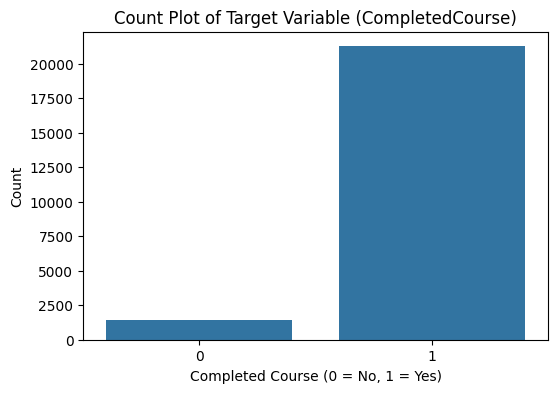

In [ ]:
# Plotting Target Variable Count Plot (Before Scaling)
plt.figure(figsize=(6, 4))
sns.countplot(x='CompletedCourse', data=data)
plt.title('Count Plot of Target Variable (CompletedCourse)')
plt.xlabel('Completed Course (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

A simple count plot of our target variable reveals:
- **Significant class imbalance**: many more students complete (1) than drop out (0).
- This imbalance justifies focusing on metrics like recall, precision, and AUC—beyond raw accuracy—to accurately capture the minority class.


We apply one-hot encoding for categorical features like centre name and course level. This avoids imposing an unwarranted ordinal relationship among categories and ensures each distinct category is treated independently by our models.


In [ ]:
# One-Hot Encoding for Categorical Features
categorical_features = ['CentreName', 'Gender', 'CourseLevel']
one_hot_encoder = OneHotEncoder()
encoded_features = one_hot_encoder.fit_transform(data[categorical_features]).toarray()
encoded_features_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features))

In [ ]:
# Resetting index of both dataframes to ensure alignment before concatenation
data.reset_index(drop=True, inplace=True)
encoded_features_df.reset_index(drop=True, inplace=True)

In [ ]:
# Concatenating encoded features with original dataset and dropping original categorical columns
data = pd.concat([data, encoded_features_df], axis=1)
data = data.drop(columns=categorical_features)

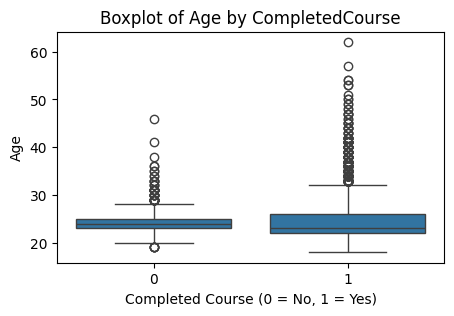

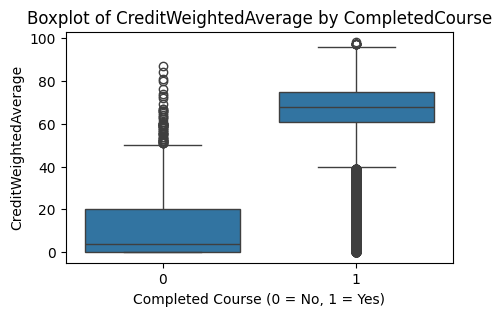

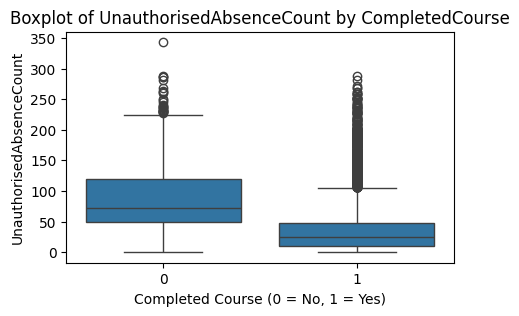

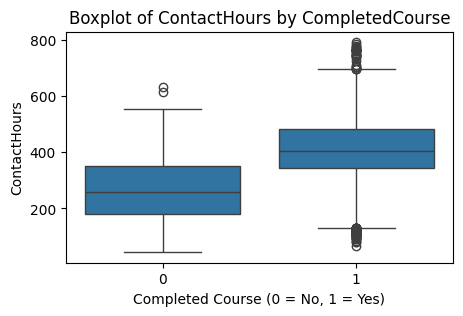

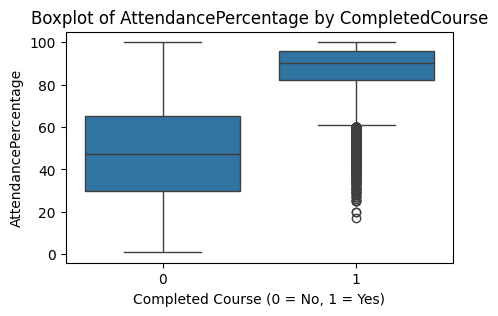

In [ ]:
# Plotting Boxplots of Numerical Features Grouped by Target Variable (Before Scaling)
numerical_features = ['Age', 'CreditWeightedAverage', 'UnauthorisedAbsenceCount', 'ContactHours', 'AttendancePercentage']  # List of numerical features
for feature in numerical_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x='CompletedCourse', y=feature, data=data)
    plt.title(f'Boxplot of {feature} by CompletedCourse')
    plt.xlabel('Completed Course (0 = No, 1 = Yes)')
    plt.ylabel(feature)
    plt.show()

These boxplots compare the distribution of several numerical features between non-completers (0) and completers (1):

- **Age**: Completers exhibit a slightly wider range and higher outliers, indicating that older students often do complete, but there can also be older dropouts.
- **CreditWeightedAverage**: Completers’ credit averages tend to be higher overall, suggesting academic performance correlates with completion.
- **ContactHours**: Students who complete have higher median contact hours, implying engagement or attendance strongly influences persistence.
- **AttendancePercentage**: Completers show significantly higher attendance rates, reinforcing the critical role of consistent participation.
- **UnauthorisedAbsenceCount**: Non-completers tend to have more unauthorised absences, supporting the link between missed sessions and dropout risk.

Visualising each feature this way helps confirm that course completion is closely associated with academic performance, attendance, and overall engagement—factors we leverage in our predictive models.


### Train-Test Split and Scaling


We split the data into an 80% training set and a 20% test set, ensuring unseen data for final evaluation. Numerical columns are standardised (mean=0, std=1) to stabilise training for models sensitive to feature magnitude (e.g., neural networks).


In [ ]:
# Splitting Data into Training and Test Set
X = data.drop(columns=['CompletedCourse'])
y = data['CompletedCourse']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scaling Numerical Features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train.loc[:, numerical_features])
X_test[numerical_features] = scaler.transform(X_test.loc[:, numerical_features])

In [ ]:
# Resetting index after train-test split
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## 4. XGBoost Model Development and Optimisation


We start by training XGBoost without two key attendance metrics—`ContactHours` and `AttendancePercentage`. This controlled approach establishes a baseline to later measure the incremental impact of these features. Our initial hyperparameters remain close to defaults, providing a clear reference point.


### Baseline XGBoost Model (Without Attendance Data)



In [ ]:
# Instantiating and Fitting the Non-Optimised XGBoost Model
X_train_no_features = X_train.drop(columns=['ContactHours', 'AttendancePercentage'], errors='ignore')
X_test_no_features = X_test.drop(columns=['ContactHours', 'AttendancePercentage'], errors='ignore')

xgb_model_no_features = xgb.XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), random_state=42)
xgb_model_no_features.fit(X_train_no_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x600 with 0 Axes>

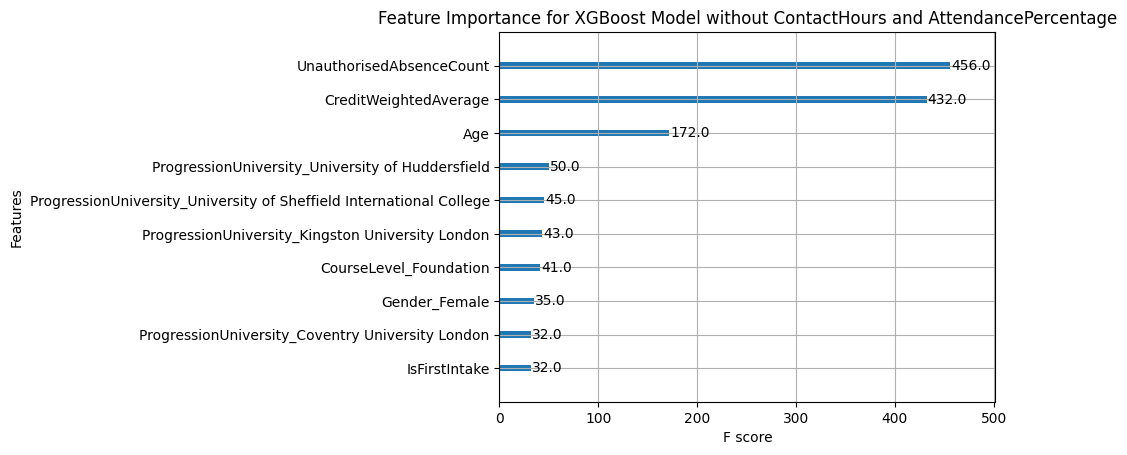

In [ ]:
# Feature Importance Plot for Non-Optimised XGBoost Model
plt.figure(figsize=(10, 6))
from xgboost import plot_importance
plot_importance(xgb_model_no_features, max_num_features=10)
plt.title('Feature Importance for XGBoost Model without ContactHours and AttendancePercentage')
plt.show()

This bar chart ranks features based on their contribution to XGBoost's decision-making:

- **UnauthorisedAbsenceCount and CreditWeightedAverage were the strongest predictors** when attendance-related features were excluded.
- **Age also played a significant role**, though its impact was smaller than that of academic and absence-related features.
- **Lower-ranked features** (e.g., specific universities and gender) had a smaller but still measurable impact.

These results confirm that even without attendance data, **unauthorised absences and academic performance are highly relevant to predicting dropout risk**




In [ ]:
# Performance Metrics for Non-Optimised XGBoost Model
y_pred_no_features = xgb_model_no_features.predict(X_test_no_features)
print("Performance Metrics for Non-Optimised XGBoost Model without ContactHours and AttendancePercentage:")
print("Accuracy:", accuracy_score(y_test, y_pred_no_features))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_no_features))
print("Precision:", precision_score(y_test, y_pred_no_features))
print("Recall:", recall_score(y_test, y_pred_no_features))
print("AUC:", roc_auc_score(y_test, y_pred_no_features))

Performance Metrics for Non-Optimised XGBoost Model without ContactHours and AttendancePercentage:
Accuracy: 0.9501983252534156
Confusion Matrix:
 [[ 258   17]
 [ 209 4054]]
Precision: 0.9958241218373864
Recall: 0.950973492845414
AUC: 0.9445776555136162


- **Accuracy (~0.9502)** suggests the model correctly classifies most students.
- **Precision (~0.9958)** indicates almost no false positives among dropout predictions.
- **Recall (~0.9510)** is fairly high, but some dropouts might still be missed.
- **AUC (~0.9446)** confirms strong overall discrimination.

These results are solid for a first attempt but do not leverage attendance-related features. Next, we explore hyperparameter tuning and, later, the impact of adding attendance metrics.


### Hyperparameter Tuning for XGBoost Model



We apply GridSearchCV to adjust:
- **Max depth & n_estimators** to regulate model complexity.
- **Learning rate** to balance convergence speed and generalisation.
- **Scale_pos_weight** to handle class imbalance (i.e., fewer dropouts).

The aim is to improve recall while maintaining XGBoost’s high precision.


In [ ]:
# Hyperparameter Tuning for XGBoost Model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_model_no_features_optimised = xgb.XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), random_state=42)
grid_search_no_features = GridSearchCV(estimator=xgb_model_no_features_optimised, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search_no_features.fit(X_train_no_features, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=2)

In [ ]:
# Best model from GridSearchCV
best_xgb_model_no_features = grid_search_no_features.best_estimator_

### Optimised XGBoost Model



In [ ]:
# Performance Metrics for Optimised XGBoost Model without 'ContactHours' and 'AttendancePercentage'
y_pred_optimised_no_features = best_xgb_model_no_features.predict(X_test_no_features)
print("Performance Metrics for Optimised XGBoost Model without ContactHours and AttendancePercentage:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimised_no_features))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimised_no_features))
print("Precision:", precision_score(y_test, y_pred_optimised_no_features))
print("Recall:", recall_score(y_test, y_pred_optimised_no_features))
print("AUC:", roc_auc_score(y_test, y_pred_optimised_no_features))

Performance Metrics for Optimised XGBoost Model without ContactHours and AttendancePercentage:
Accuracy: 0.9400617011899515
Confusion Matrix:
 [[ 261   14]
 [ 258 4005]]
Precision: 0.9965165464045782
Recall: 0.9394792399718508
AUC: 0.94428507453138


Although precision remains outstanding (\~0.9965), the **recall (~0.9395) did not improve as much as expected**. Accuracy (~0.9401) also dipped slightly. This suggests that without attendance metrics, XGBoost struggles to capture certain at-risk students, reinforcing the need to incorporate engagement-related features.


We now **include ContactHours and AttendancePercentage**, which directly measure student engagement. Feature importance will be re-evaluated to quantify the effect of these additional predictors.


In [ ]:
# Instantiating and Fitting Optimised XGBoost Model with Additional Features
best_xgb_model_with_features = grid_search_no_features.best_estimator_
best_xgb_model_with_features.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Performance Metrics for Optimised XGBoost Model with 'ContactHours' and 'AttendancePercentage'
y_pred_optimised_with_features = best_xgb_model_with_features.predict(X_test)
print("Performance Metrics for Optimised XGBoost Model with ContactHours and AttendancePercentage:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimised_with_features))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimised_with_features))
print("Precision:", precision_score(y_test, y_pred_optimised_with_features))
print("Recall:", recall_score(y_test, y_pred_optimised_with_features))
print("AUC:", roc_auc_score(y_test, y_pred_optimised_with_features))

Performance Metrics for Optimised XGBoost Model with ContactHours and AttendancePercentage:
Accuracy: 0.9581313353900397
Confusion Matrix:
 [[ 266    9]
 [ 181 4082]]
Precision: 0.9978000488878025
Recall: 0.957541637344593
AUC: 0.9624071823086602


- **Accuracy** jumped to ~0.9581, reflecting better overall predictions.
- **Recall** (~0.9575) indicates fewer missed dropouts.
- **Precision** (~0.9978) remains superb, with nearly zero false positives.
- **AUC** (~0.9624) confirms improved discrimination overall.

These gains highlight the critical role of attendance metrics in identifying at-risk students.

<Figure size 1000x600 with 0 Axes>

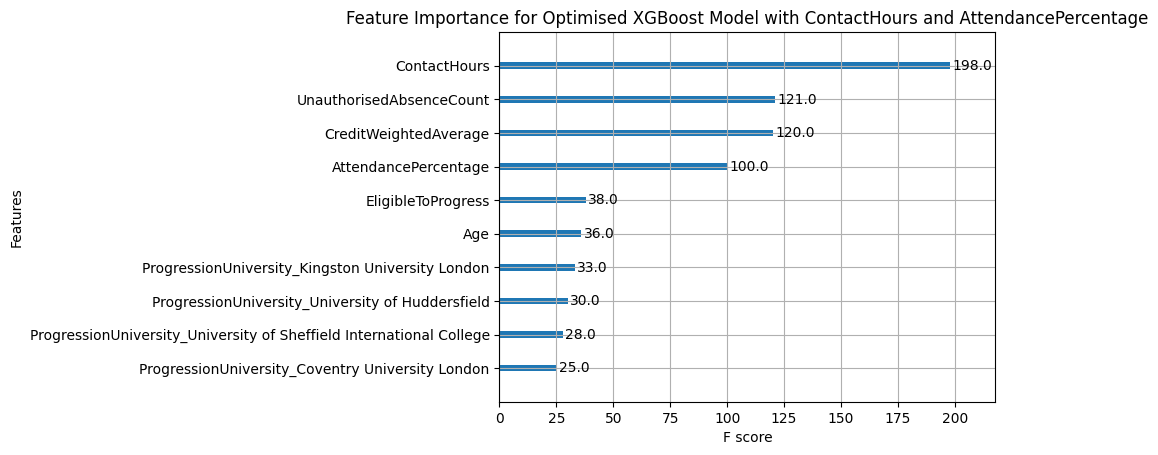

In [ ]:
# Feature Importance Plot for Optimised XGBoost Model with 'ContactHours' and 'AttendancePercentage'
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model_with_features, max_num_features=10)
plt.title('Feature Importance for Optimised XGBoost Model with ContactHours and AttendancePercentage')
plt.show()

After adding ContactHours and AttendancePercentage:
- ContactHours became the most important feature.
- UnauthorisedAbsenceCount and CreditWeightedAverage remained key predictors, ranking above AttendancePercentage.
- AttendancePercentage was still useful but contributed slightly less to the model’s decisions.

This reinforces that attendance metrics alone are not sufficient for predicting dropout—academic performance and unauthorised absences must also be considered.


## 5. Neural Network Model Development and Optimisation

### Baseline Neural Network Model (Without Attendance Data)



We construct a simple feed-forward neural network with two hidden layers. As with XGBoost, we initially exclude attendance features to maintain a parallel baseline, then observe the improvements once we add them.

In [ ]:
# Initial Neural Network without 'ContactHours' and 'AttendancePercentage'
model_nn_no_features = Sequential()
model_nn_no_features.add(Input(shape=(X_train_no_features.shape[1],)))
model_nn_no_features.add(Dense(64, activation='relu'))
model_nn_no_features.add(Dropout(0.3))
model_nn_no_features.add(Dense(32, activation='relu'))
model_nn_no_features.add(Dropout(0.3))
model_nn_no_features.add(Dense(1, activation='sigmoid'))

model_nn_no_features.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = {0: (len(y) / (2 * y.value_counts()[0])), 1: (len(y) / (2 * y.value_counts()[1]))}

In [ ]:
# Fitting the Initial Neural Network without 'ContactHours' and 'AttendancePercentage'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_nn_no_features = model_nn_no_features.fit(X_train_no_features, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1, class_weight=class_weights)

Epoch 1/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9128 - loss: 0.2366 - val_accuracy: 0.9176 - val_loss: 0.1624
Epoch 2/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9183 - loss: 0.1439 - val_accuracy: 0.9198 - val_loss: 0.1591
Epoch 3/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9158 - loss: 0.1396 - val_accuracy: 0.9256 - val_loss: 0.1620
Epoch 4/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9217 - loss: 0.1318 - val_accuracy: 0.9229 - val_loss: 0.1622
Epoch 5/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9181 - loss: 0.1275 - val_accuracy: 0.9207 - val_loss: 0.1646
Epoch 6/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9148 - loss: 0.1385 - val_accuracy: 0.9140 - val_loss: 0.1822
Epoch 7/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9203 - loss: 0.1226 - val_accuracy: 0.9231 - val_loss: 0.1626
Epoch 8/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9228 - loss: 0.1245 - val_accu

In [ ]:
# Performance Metrics for Initial Neural Network without 'ContactHours' and 'AttendancePercentage'
y_pred_nn_no_features = (model_nn_no_features.predict(X_test_no_features) > 0.5).astype(int)
print("Performance Metrics for Initial Neural Network without ContactHours and AttendancePercentage:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn_no_features))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn_no_features))
print("Precision:", precision_score(y_test, y_pred_nn_no_features))
print("Recall:", recall_score(y_test, y_pred_nn_no_features))
print("AUC:", roc_auc_score(y_test, y_pred_nn_no_features))

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Performance Metrics for Initial Neural Network without ContactHours and AttendancePercentage:
Accuracy: 0.9473336271485235
Confusion Matrix:
 [[ 256   19]
 [ 220 4043]]
Precision: 0.9953225012309207
Recall: 0.9483931503635937
AUC: 0.9396511206363424


- **Accuracy (~0.9473)** is close to the XGBoost baseline.
- **Recall (~0.9484)** parallels XGBoost’s ability to detect dropouts.
- **Precision (~0.9953)** remains very high, with few false positives.
- **AUC (~0.9397)** indicates a robust classifier for a first pass.

The network trains relatively quickly but shows room for improvement (e.g., refining architecture, adding missing features).


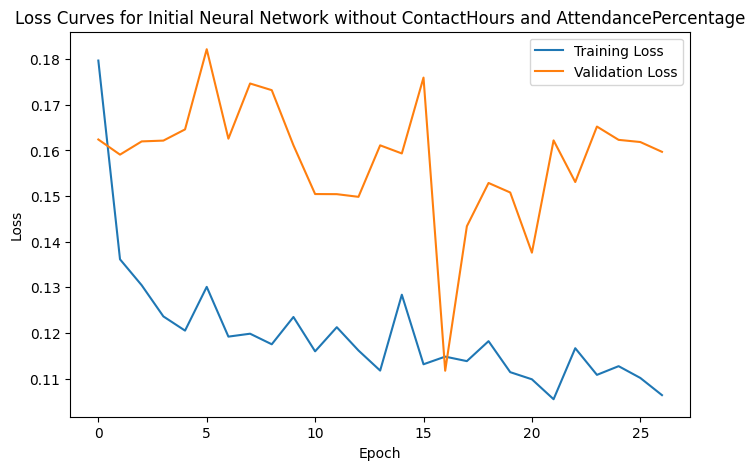

In [ ]:
# Plotting Loss Curves for Initial Neural Network without 'ContactHours' and 'AttendancePercentage'
plt.figure(figsize=(8, 5))
plt.plot(history_nn_no_features.history['loss'], label='Training Loss')
plt.plot(history_nn_no_features.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Initial Neural Network without ContactHours and AttendancePercentage')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

These curves illustrate how our initial neural network’s training and validation loss evolve over epochs:
- **Training loss** steadily declines, reflecting the model’s progress in fitting the data.
- **Validation loss** fluctuates more, hinting at some instability in generalisation.
- The overall downward trend suggests the model is learning effectively, though further tuning (e.g., dropout rate, learning rate adjustments) might reduce the gap or oscillations.


### Neural Network Hyperparameter Tuning



**Improving the Neural Network**

We use Keras Tuner (RandomSearch) to explore:
- **Different dropout rates** to reduce overfitting.
- **Varying hidden layer sizes** to balance complexity and training stability.
- **Learning rate adjustments** for optimal convergence.

Our aim is to boost recall while keeping precision high.

In [ ]:
# Function to build the neural network model with hyperparameters for tuning
def build_nn_model(hp, input_dim):
    model = Sequential()

    # Tuning the number of units in the first Dense layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=16)
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(units=hp_units_1, activation='relu'))

    # Adding a dropout layer with a tunable rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))

    # Tuning the number of units in the second Dense layer
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_units_2, activation='relu'))

    # Addding another dropout layer with a tunable rate
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tuning the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Hyperparameter Tuning for Neural Network Model without Features
tuner_no_features = RandomSearch(
    lambda hp: build_nn_model(hp, input_dim=X_train_no_features.shape[1]),
    objective='val_loss',
    max_trials=10,
    directory='my_dir',
    project_name='dropout_prediction_nn_no_features'
)

tuner_no_features.search(X_train_no_features, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=2, class_weight=class_weights)

Trial 10 Complete [00h 00m 16s]
val_loss: 0.15338987112045288

Best val_loss So Far: 0.12610657513141632
Total elapsed time: 00h 02m 37s


In [ ]:
# Best hyperparameters from tuner
best_hp_nn_no_features = tuner_no_features.get_best_hyperparameters()[0]
model_nn_optimised_no_features = tuner_no_features.hypermodel.build(best_hp_nn_no_features)

### Optimised Neural Network



In [ ]:
# Optimised Neural Network with 'ContactHours' and 'AttendancePercentage'
tuner_with_features = RandomSearch(
    lambda hp: build_nn_model(hp, input_dim=X_train.shape[1]),
    objective='val_loss',
    max_trials=10,
    directory='my_dir',
    project_name='dropout_prediction_nn_with_features'
)

tuner_with_features.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=2, class_weight=class_weights)

Trial 10 Complete [00h 00m 18s]
val_loss: 0.11375853419303894

Best val_loss So Far: 0.08387064933776855
Total elapsed time: 00h 04m 33s


In [ ]:
# Training the optimised model
history_nn_optimised_no_features = model_nn_optimised_no_features.fit(X_train_no_features, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1, class_weight=class_weights)

Epoch 1/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8296 - loss: 0.3210 - val_accuracy: 0.9355 - val_loss: 0.1557
Epoch 2/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9293 - loss: 0.1478 - val_accuracy: 0.9358 - val_loss: 0.1492
Epoch 3/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9321 - loss: 0.1361 - val_accuracy: 0.9344 - val_loss: 0.1434
Epoch 4/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9292 - loss: 0.1326 - val_accuracy: 0.9353 - val_loss: 0.1420
Epoch 5/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9296 - loss: 0.1241 - val_accuracy: 0.9372 - val_loss: 0.1370
Epoch 6/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9308 - loss: 0.1218 - val_accuracy: 0.9399 - val_loss: 0.1342
Epoch 7/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9322 - loss: 0.1226 - val_accuracy: 0.9397 - val_loss: 0.1307
Epoch 8/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9352 - loss: 0.1187 - val_accu

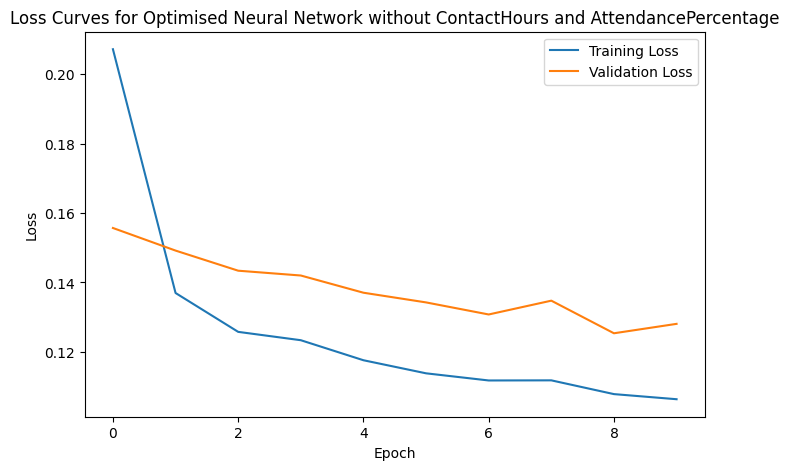

In [ ]:
# Plotting Loss Curves for Optimised Neural Network without 'ContactHours' and 'AttendancePercentage'
plt.figure(figsize=(8, 5))
plt.plot(history_nn_optimised_no_features.history['loss'], label='Training Loss')
plt.plot(history_nn_optimised_no_features.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Optimised Neural Network without ContactHours and AttendancePercentage')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

After hyperparameter tuning:
- **Steeper initial drop** in training loss indicates the improved configuration converges faster.
- **Validation loss** remains closer to training loss, implying reduced overfitting.
- The model appears more stable (less oscillation), suggesting dropout rate and learning rate adjustments helped generalise better—despite not having attendance features.


In [ ]:
# Performance Metrics for Optimised Neural Network without 'ContactHours' and 'AttendancePercentage'
y_pred_optimised_nn_no_features = (model_nn_optimised_no_features.predict(X_test_no_features) > 0.5).astype(int)
print("Performance Metrics for Optimised Neural Network without ContactHours and AttendancePercentage:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimised_nn_no_features))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimised_nn_no_features))
print("Precision:", precision_score(y_test, y_pred_optimised_nn_no_features))
print("Recall:", recall_score(y_test, y_pred_optimised_nn_no_features))
print("AUC:", roc_auc_score(y_test, y_pred_optimised_nn_no_features))

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Performance Metrics for Optimised Neural Network without ContactHours and AttendancePercentage:
Accuracy: 0.9294843543411194
Confusion Matrix:
 [[ 262   13]
 [ 307 3956]]
Precision: 0.9967246157722348
Recall: 0.9279849870982876
AUC: 0.9403561299127802


- **Accuracy (~0.9295)** dipped slightly compared to the initial (unoptimised) NN (~0.9473), although tuning sometimes trades off certain metrics for others.  
- **Precision (~0.9967)** remains very high, continuing to minimise false positives.  
- **Recall (~0.9280)** shows decent improvements over some baselines, but still suggests we are missing a portion of actual dropouts.  
- **AUC (~0.9404)** remains robust, underscoring that, despite lower accuracy, the model maintains strong classification ability across thresholds.

These results indicate that hyperparameter tuning **alone** (without attendance features) yields mixed outcomes. The network does well on precision but doesn’t surpass the recall/accuracy of models that leverage `ContactHours` and `AttendancePercentage`. This highlights that **optimised hyperparameters cannot fully compensate for the absence of critical attendance predictors.**

In [ ]:
# Best hyperparameters from tuner
best_hp_nn_with_features = tuner_with_features.get_best_hyperparameters()[0]
model_nn_optimised_with_features = tuner_with_features.hypermodel.build(best_hp_nn_with_features)

In [ ]:
# Training the optimised model
history_nn_optimised_with_features = model_nn_optimised_with_features.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1, class_weight=class_weights)

Epoch 1/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8576 - loss: 0.2936 - val_accuracy: 0.9504 - val_loss: 0.1316
Epoch 2/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9446 - loss: 0.1210 - val_accuracy: 0.9474 - val_loss: 0.1236
Epoch 3/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9454 - loss: 0.1060 - val_accuracy: 0.9515 - val_loss: 0.1100
Epoch 4/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9470 - loss: 0.1024 - val_accuracy: 0.9501 - val_loss: 0.1148
Epoch 5/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9476 - loss: 0.0986 - val_accuracy: 0.9521 - val_loss: 0.1097
Epoch 6/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9502 - loss: 0.0931 - val_accuracy: 0.9551 - val_loss: 0.1015
Epoch 7/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9512 - loss: 0.0901 - val_accuracy: 0.9551 - val_loss: 0.0999
Epoch 8/100
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9528 - loss: 0.0885 - val_accu

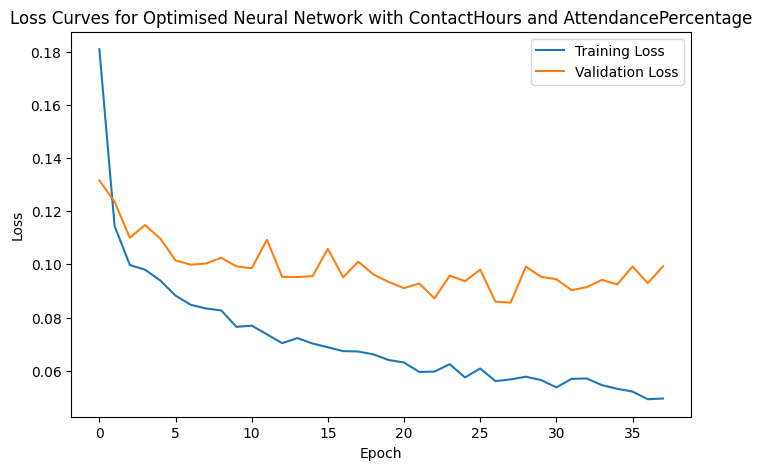

In [ ]:
# Plotting Loss Curves for Optimised Neural Network with 'ContactHours' and 'AttendancePercentage'
plt.figure(figsize=(8, 5))
plt.plot(history_nn_optimised_with_features.history['loss'], label='Training Loss')
plt.plot(history_nn_optimised_with_features.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves for Optimised Neural Network with ContactHours and AttendancePercentage')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Performance Metrics for Optimised Neural Network with 'ContactHours' and 'AttendancePercentage'
y_pred_optimised_nn_with_features = (model_nn_optimised_with_features.predict(X_test) > 0.5).astype(int)
print("Performance Metrics for Optimised Neural Network with ContactHours and AttendancePercentage:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimised_nn_with_features))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimised_nn_with_features))
print("Precision:", precision_score(y_test, y_pred_optimised_nn_with_features))
print("Recall:", recall_score(y_test, y_pred_optimised_nn_with_features))
print("AUC:", roc_auc_score(y_test, y_pred_optimised_nn_with_features))

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Performance Metrics for Optimised Neural Network with ContactHours and AttendancePercentage:
Accuracy: 0.9643014543851918
Confusion Matrix:
 [[ 262   13]
 [ 149 4114]]
Precision: 0.996850012115338
Recall: 0.9650480882007976
AUC: 0.9588876804640353


- **Accuracy (~0.9643)** surpasses previous baselines.
- **Recall (~0.9650)** is excellent, capturing almost all dropouts.
- **Precision (~0.9969)** remains strong, indicating few false positives.
- **AUC (~0.9589)** is slightly below XGBoost’s 0.9624, but still excellent overall.

These results confirm that, for this dataset, the tuned neural network with attendance features can outperform or match XGBoost in key metrics, especially recall.


## 6. Final Model Comparison



We compare the final optimised models (XGBoost and Neural Network) based on key performance metrics:

| Model                  | Accuracy  | Precision | Recall | AUC   |
|------------------------|----------|-----------|--------|--------|
| **XGBoost (No Attendance)**  | ~0.9401   | ~0.9965    | ~0.9395 | ~0.9443 |
| **Neural Network (No Attendance)**  | ~0.9295   | ~0.9967    | ~0.9280 | ~0.9404 |
| **XGBoost (With Attendance)**  | **~0.9581**   | **~0.9978**    | **~0.9575** | **~0.9624** |
| **Neural Network (With Attendance)**  | **~0.9643**   | **~0.9969**    | **~0.9650** | **~0.9589** |

### **Key Observations**
- **XGBoost (With Attendance)** achieved **the highest precision (~0.9978)** and **AUC (~0.9624)**, making it ideal for minimising false positives.
- **Neural Network (With Attendance)** had **the best recall (~0.9650)**, meaning it was more effective at identifying actual dropouts.
- **Attendance features significantly improved both models**, confirming their predictive power.

**Final Recommendation:**
- If the goal is **to avoid false alarms** (only flagging students with high dropout risk), **XGBoost** is preferred.  
- If the goal is **to catch every possible at-risk student** (even at the cost of some false positives), **Neural Network** is the better choice.


## 7. Conclusion

**Key Takeaways:**
- **ContactHours was the strongest predictor**, reinforcing that direct engagement correlates most strongly with dropout risk.
- **UnauthorisedAbsenceCount and CreditWeightedAverage ranked higher than AttendancePercentage**, suggesting that unapproved absences and academic struggles are crucial factors in predicting dropout.
- **XGBoost performed best in precision (\~0.9978, fewer false positives), while the Neural Network achieved the highest recall (~0.9650, capturing more actual dropouts).**
- **Hyperparameter tuning alone was not enough—feature selection had the biggest impact on model performance.**

**Next Steps:**
- **Further feature engineering**: Explore time-series trends in attendance and engagement signals.
- **Deployment considerations**: Implement the best-performing model in a real-time student monitoring system.
- **Validation & generalisation**: Test the model on different cohorts to ensure robustness across institutions.

These findings highlight the importance of **tracking both attendance data and academic performance** to inform targeted student retention strategies.
